### GS-BBVI Demonstration (NASCAR)
 - Generate NASCAR tracetrack with different dynamics for different states.  
 - Sample latent state z and latent trajectory x simultaneously using initialized mean trajectory.

In [1]:
from bbvi_infer import *
%matplotlib inline
print(torch.cuda.is_available())

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


### NASCAR race track  

In [2]:
import ssm
from ssm.util import random_rotation, find_permutation
def make_nascar_model(D_obs = 10, D_latent=2, K=4, T=100):
    # ----- Dynamics per state ----------
    As = [random_rotation(D_latent, np.pi/36.),   ## different curvatures
      random_rotation(D_latent, np.pi/8.)]
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.5, 0.]))
    As.append(random_rotation(D_latent, np.pi/12.))
    bs.append(np.array([-0.5, 0.]))
    
    # ----- State divvy up the 2D space --------
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((10*w1, 10*w2, 10*w3,10*w4))
    r = np.concatenate((10*b1, 10*b2, 10*b3, 10*b4))
    
    # Generate states z, trajectories x, and observations y for T=400
    true_rslds = ssm.SLDS(D_obs, K, D_latent, 
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian", 
                      emissions="gaussian",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r
    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds
true_rslds = make_nascar_model(D_obs = 10, D_latent=2, K=4, T=400)
zs, xs, ys = true_rslds.sample(T=400) 

In [3]:
### True interaction matrix A
true_rslds.dynamics.As

array([[[ 0.9961947 ,  0.08715574],
        [-0.08715574,  0.9961947 ]],

       [[ 0.92387953,  0.38268343],
        [-0.38268343,  0.92387953]],

       [[ 1.        ,  0.        ],
        [ 0.        ,  1.        ]],

       [[ 0.96592583,  0.25881905],
        [-0.25881905,  0.96592583]]])

#### True trajectory and states

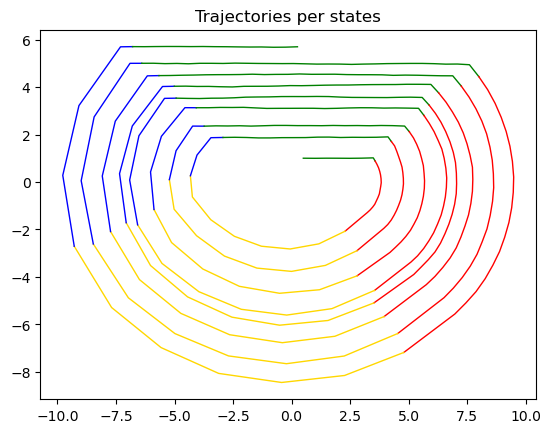

In [4]:
plot_trajectory(zs, xs, ls="-")

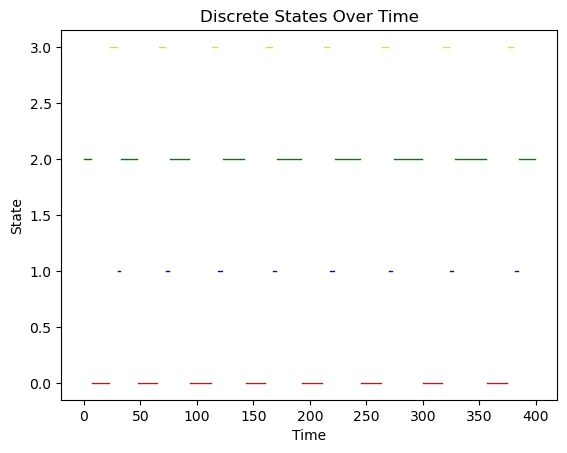

In [5]:
plot_states(zs)

### GS-BBVI inference 
We show the state and trajectory inference every 20 iterations. The learning rate follows a warm-up, decay and hold scehdule.     
The algorithm successfully recovered the true trajectory and states.   

  0%|          | 0/500 [00:00<?, ?it/s]

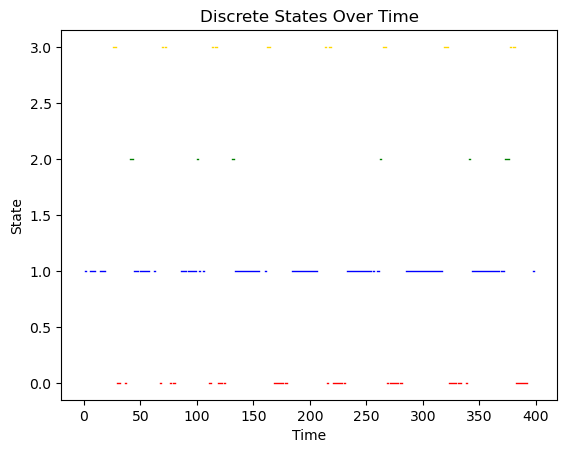

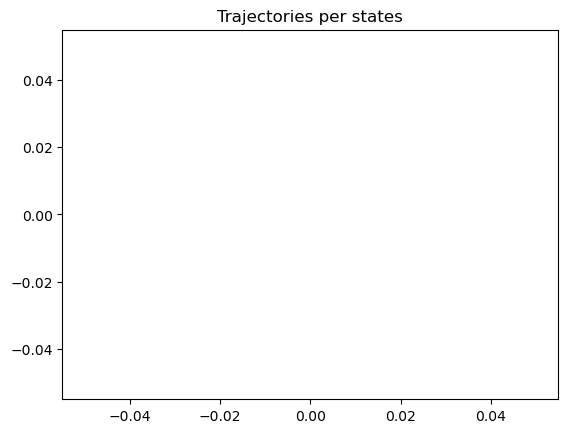

ELBO: -61355.4, LR: 0.00700, Tau: 0.990:   4%|▍         | 20/500 [01:47<42:52,  5.36s/it]

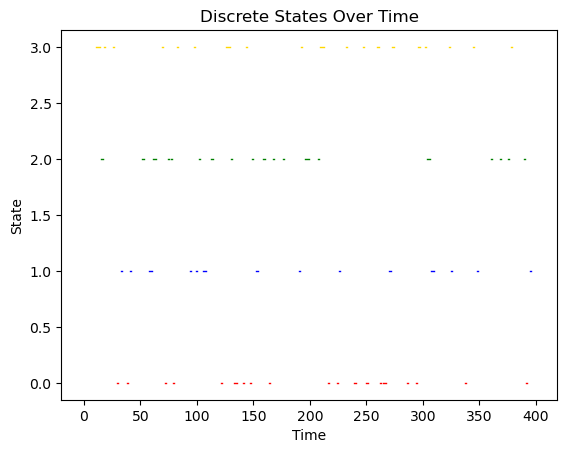

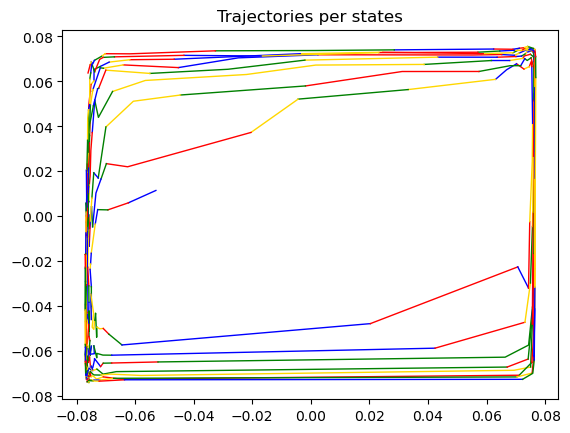

ELBO: -56335.0, LR: 0.00970, Tau: 0.990:   6%|▌         | 29/500 [02:33<39:29,  5.03s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: -49714.5, LR: 0.00940, Tau: 0.990:   8%|▊         | 40/500 [03:28<38:05,  4.97s/it]

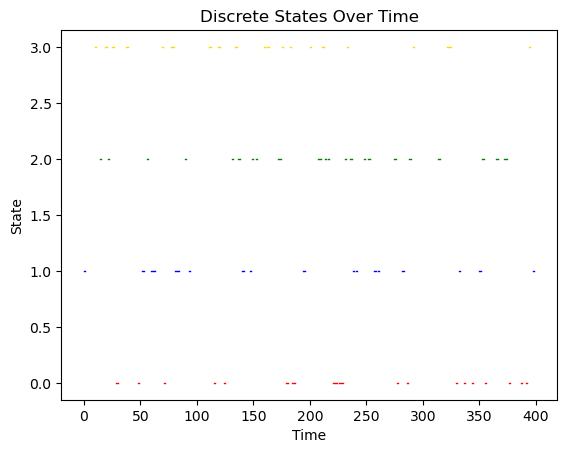

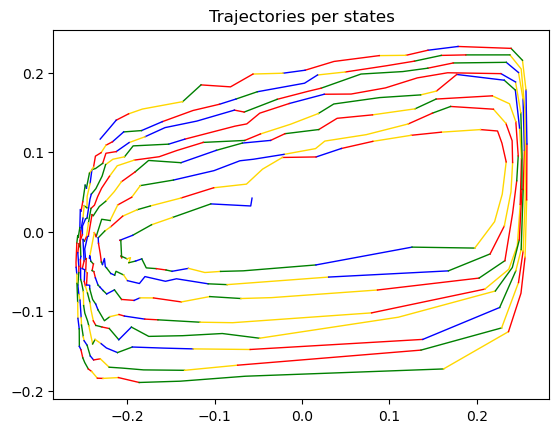

ELBO: -40574.9, LR: 0.00820, Tau: 0.990:  12%|█▏        | 60/500 [05:09<36:25,  4.97s/it]

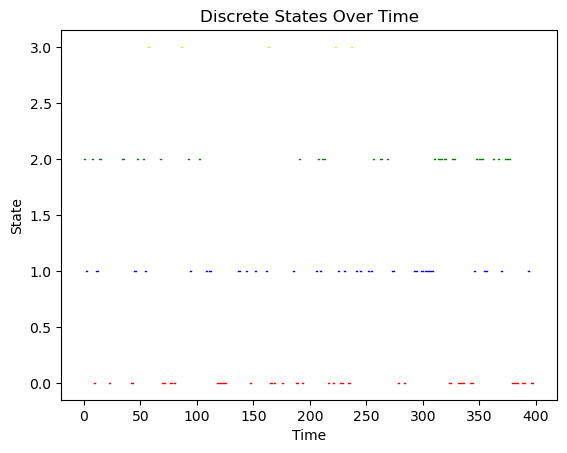

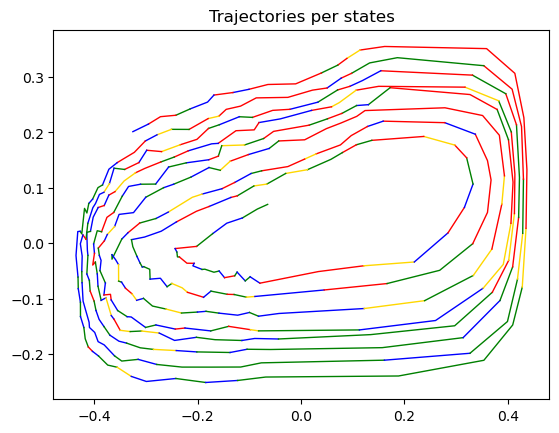

ELBO: -34217.8, LR: 0.00700, Tau: 0.990:  16%|█▌        | 80/500 [06:50<35:01,  5.00s/it]

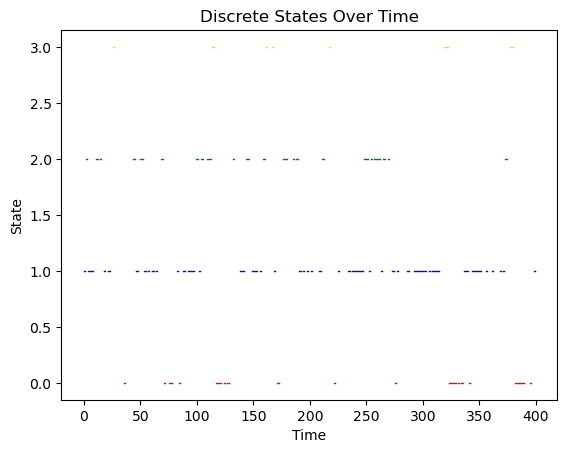

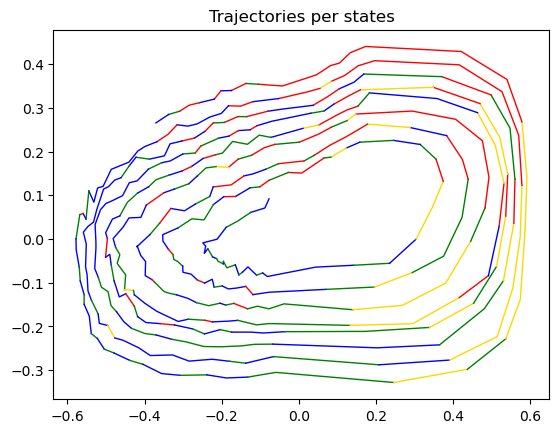

ELBO: -29895.6, LR: 0.00580, Tau: 0.990:  20%|██        | 100/500 [08:33<35:13,  5.28s/it]

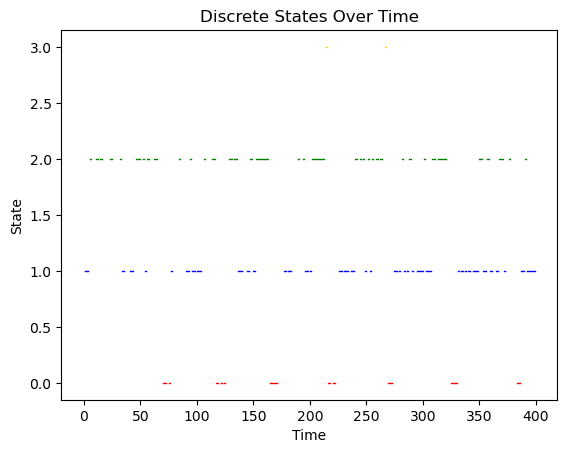

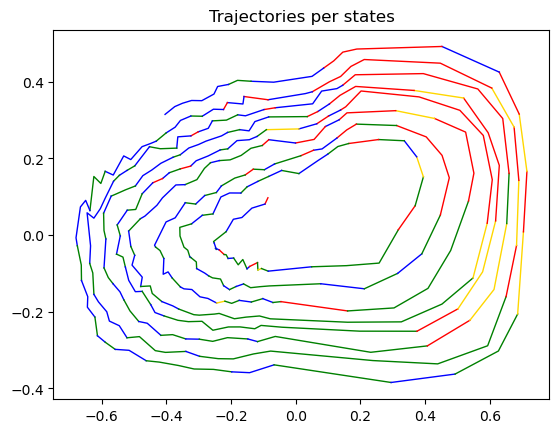

ELBO: -26924.7, LR: 0.00460, Tau: 0.990:  24%|██▍       | 120/500 [10:14<31:24,  4.96s/it]

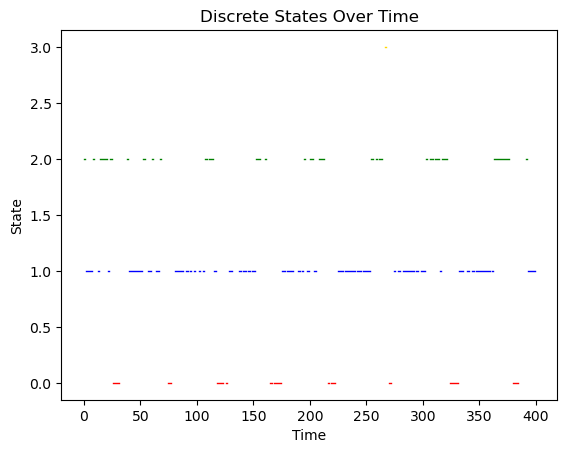

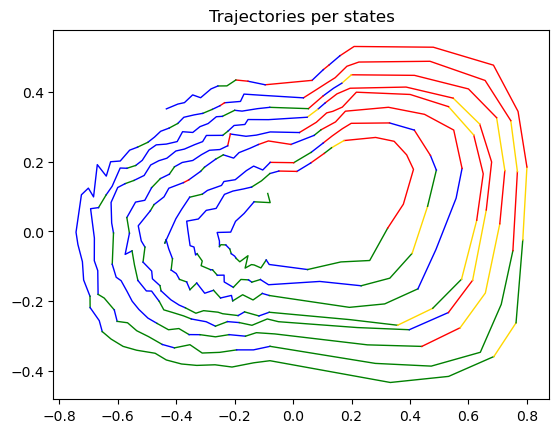

ELBO: -24822.0, LR: 0.00340, Tau: 0.990:  28%|██▊       | 140/500 [11:55<29:52,  4.98s/it]

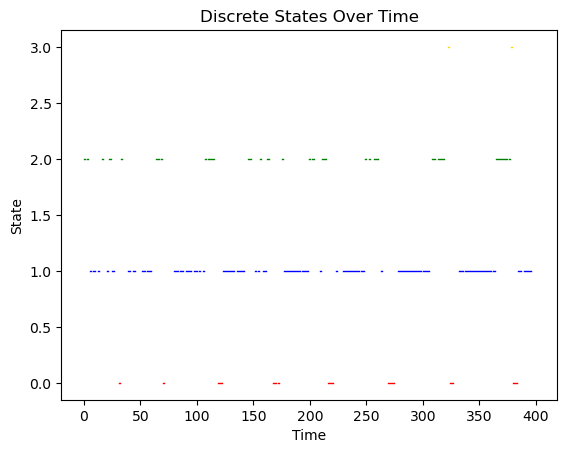

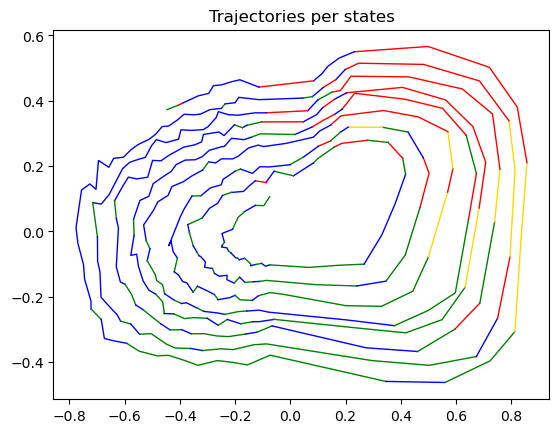

ELBO: -23893.8, LR: 0.00100, Tau: 0.990:  32%|███▏      | 160/500 [13:35<28:06,  4.96s/it]

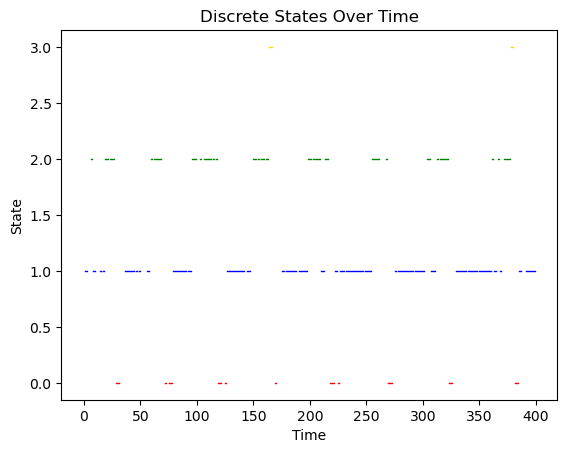

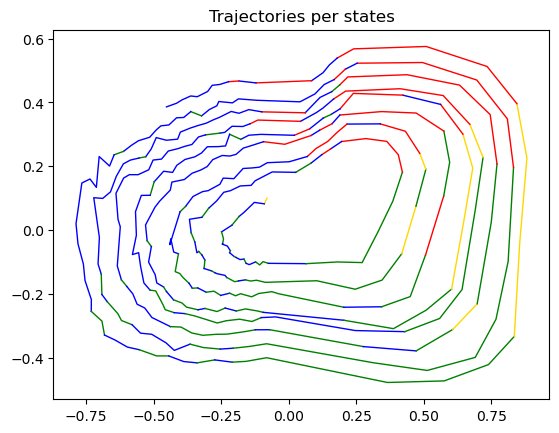

ELBO: -23407.0, LR: 0.00100, Tau: 0.990:  36%|███▌      | 180/500 [15:15<26:31,  4.97s/it]

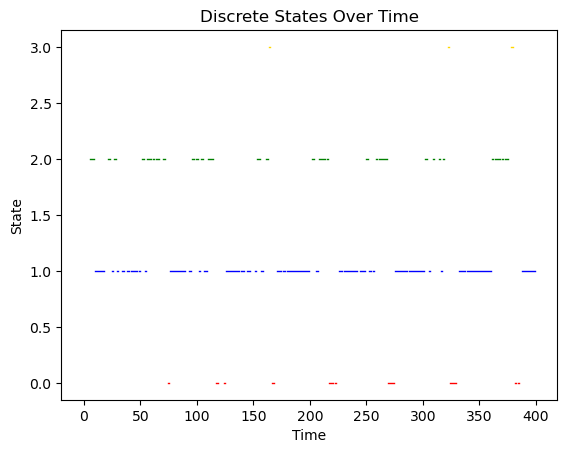

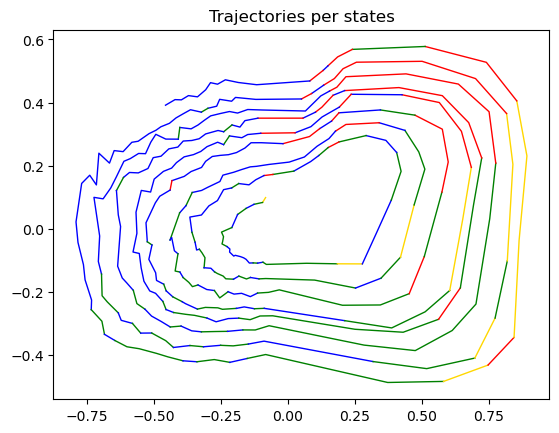

ELBO: -22993.6, LR: 0.00100, Tau: 0.990:  40%|████      | 200/500 [16:56<25:03,  5.01s/it]

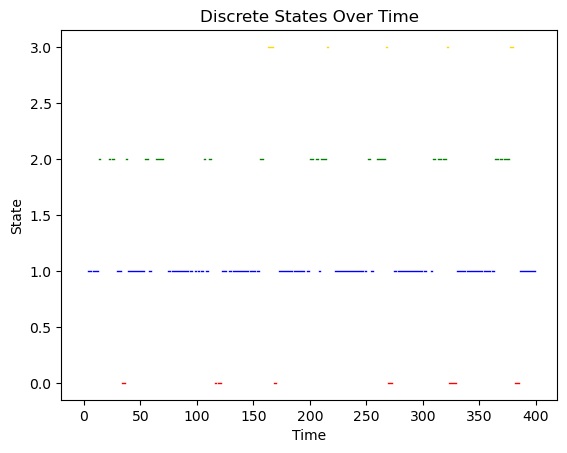

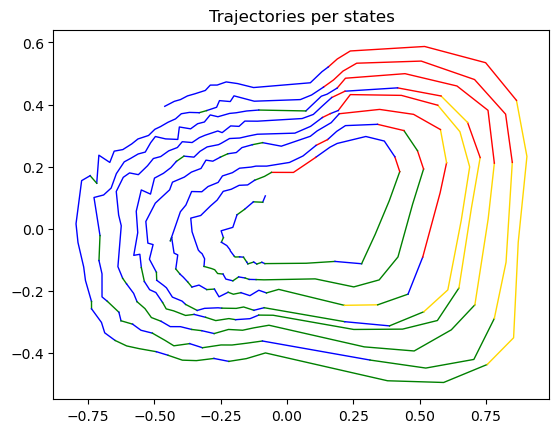

ELBO: -22577.8, LR: 0.00100, Tau: 0.990:  44%|████▍     | 220/500 [18:36<23:08,  4.96s/it]

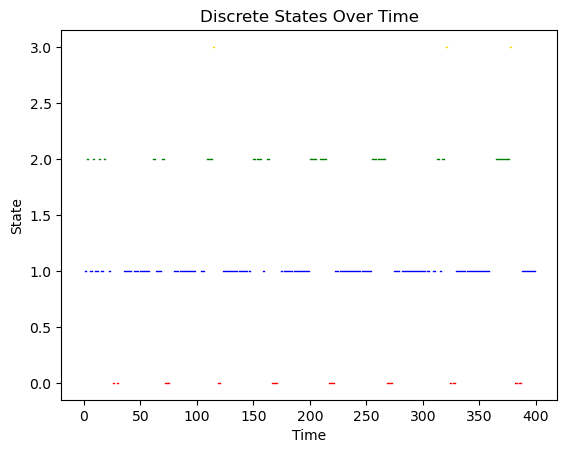

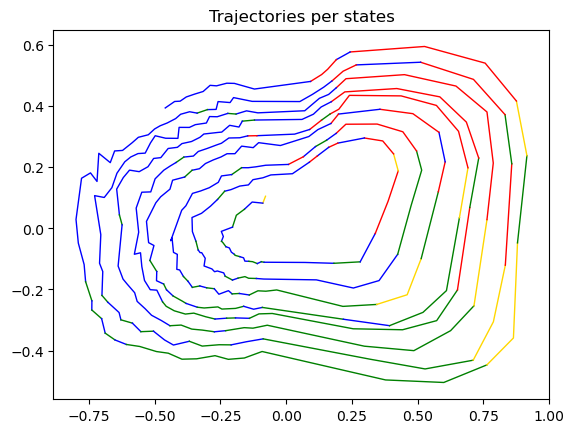

ELBO: -22169.8, LR: 0.00100, Tau: 0.990:  48%|████▊     | 240/500 [20:16<21:32,  4.97s/it]

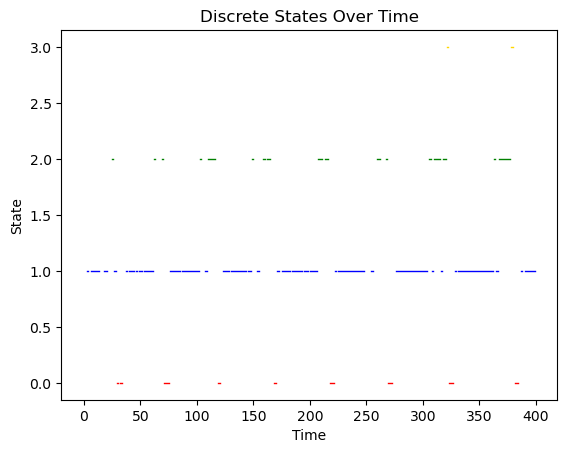

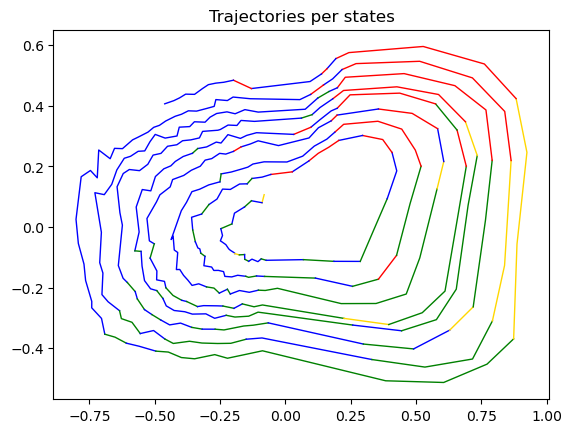

ELBO: -21818.5, LR: 0.00100, Tau: 0.990:  52%|█████▏    | 260/500 [21:56<19:48,  4.95s/it]

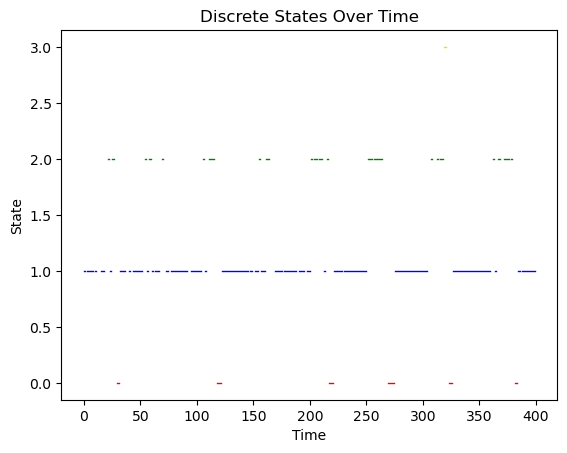

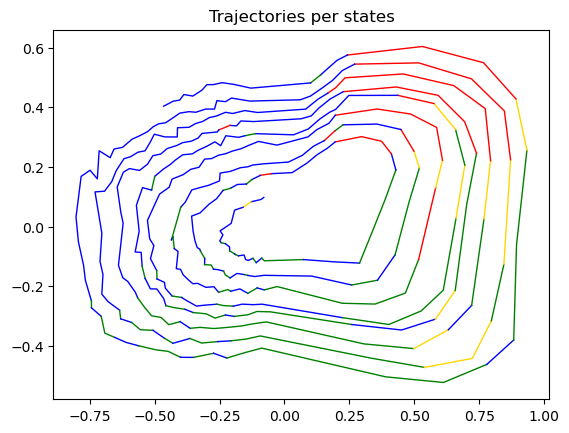

ELBO: -21488.7, LR: 0.00100, Tau: 0.990:  56%|█████▌    | 280/500 [23:41<19:26,  5.30s/it]

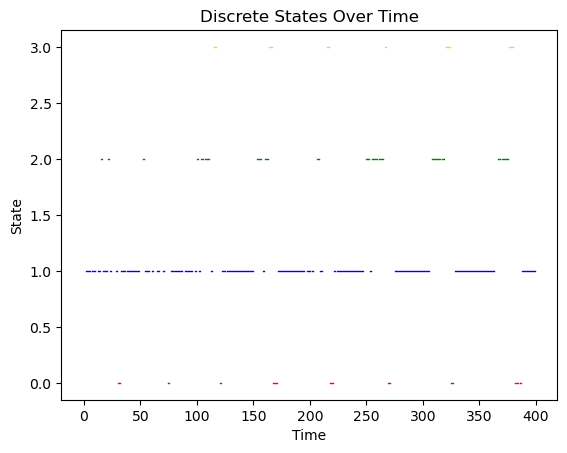

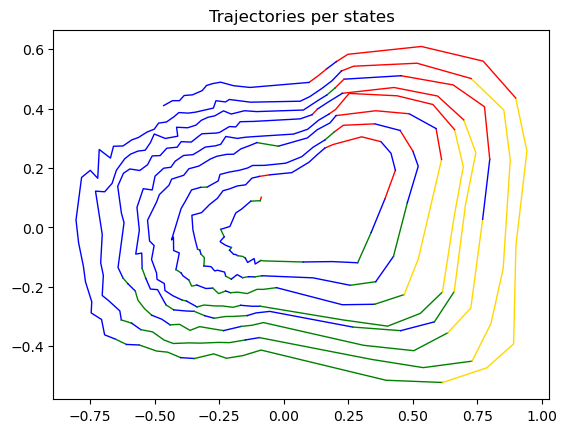

ELBO: -21102.3, LR: 0.00100, Tau: 0.990:  60%|██████    | 300/500 [25:26<17:14,  5.17s/it]

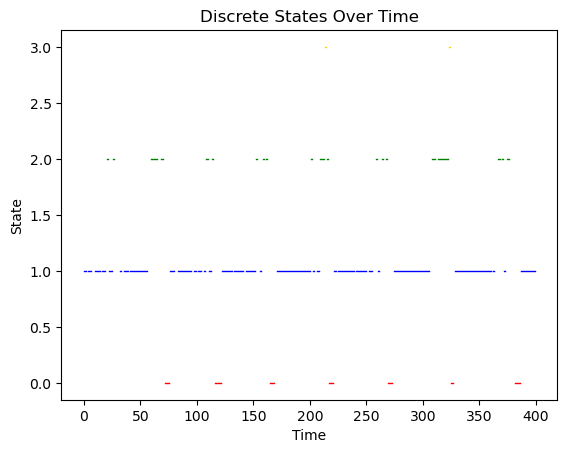

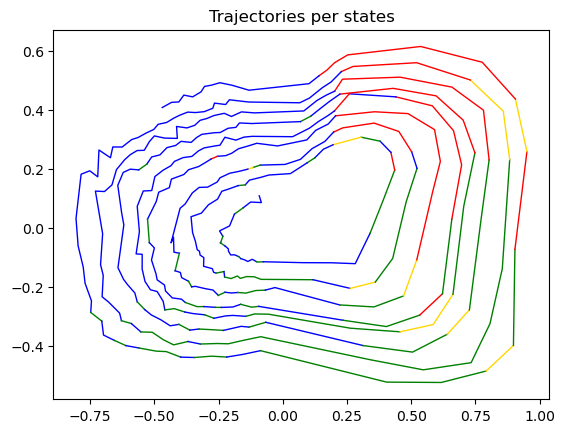

ELBO: -20975.5, LR: 0.00100, Tau: 0.990:  62%|██████▏   | 310/500 [26:23<16:10,  5.11s/it]

Early stopping at iteration 310.


In [6]:
model = GenerativeSLDS(N=10, K=4, D=2, emission_model="gaussian")
elbos, variational_x, variational_z = fit_bbvi_schedule(model.to('cuda'), ys = torch.tensor(ys).to('cuda'), xs0 = None, 
                            num_iters=500, learning=True, n_samples=5, base_lr=1e-2, warmup_iters=30, tau_max=0.99, temp_annealing=False)

Text(0, 0.5, 'ELBO')

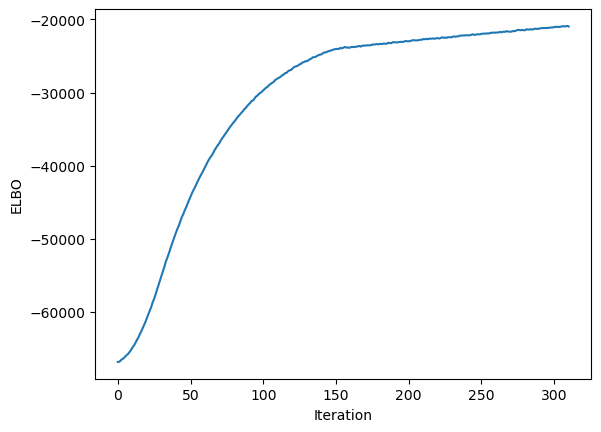

In [7]:
### ELBO
plt.figure()
plt.plot(elbos[0:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")